# Create MVImgNet bins

This notebook creates the bins for the MVImgNet dataset.

### Running for different categories 

Only need to change CLASS_NUM variable.

All categories we are using in mvimgnet:
`100  113  125  126  152  166  19  196  46  57  60  7  70  8  99`

Class `23` was excluded as it's biggest max angle = 84.257

In [1]:
CLASS_NUM = 99

In [2]:
from pathlib import Path

CONFIG = {
    "colmap_script": Path("../colmap") / "scripts" / "python", # colmap script path
    "input_path": Path("../datasets/mvimgnet"),   # base folder that contains class folders
    "output_path": Path("../datasets/split_angles_mvimagenet"),  # where to save outputs
    "angle_bins": [0, 15, 30, 45, 60, 75, 90],   # or list(range(0, 91, 15))
    "class_mapping": {7: "Stove", 8: "Sofa", 19: "Microwave", 23: "Laptop", 46: "Bed", 
                      57: "Toy Cat", 60: "Toy Cow", 70: "Toy Dragon", 99: "Coat Rack",
                      100: "Guitar Stand", 113: "Ceiling Lamp", 125: "Toilet", 126: "Sink", 
                      152: "Strings", 166: "Broccoli", 196: "Durian"}
}

### Imports

In [3]:
import os
import csv
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import math
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from datetime import datetime


### Obtain the read_write_model from python
In the open-hummingbird-eval, go to colmap, there is a scripts folder with a python which contains read_write_model.py 

The following functions are needed: 
read_images_binary & qvec2rotmat

In [4]:
# Sanity check
assert (CONFIG["colmap_script"] / "read_write_model.py").exists(), \
       f"Missing: {CONFIG['colmap_script']}/read_write_model.py"

# Add to import path and import
sys.path.append(str(CONFIG["colmap_script"]))
from read_write_model import read_images_binary, qvec2rotmat
print("OK: imported read_images_binary, qvec2rotmat")



OK: imported read_images_binary, qvec2rotmat


In [5]:
def setup_paths(CLASS_NUM, input_path, output_base):
    class_dir = input_path / str(CLASS_NUM)  # image and mask folder path
    out_dir   = output_base / str(CLASS_NUM)
    out_dir.mkdir(parents=True, exist_ok=True)
    return class_dir, out_dir


# Creating per class the (img & mask) inputs path and the output folder
class_folder_path, output_folder_path = setup_paths(CLASS_NUM, CONFIG["input_path"], CONFIG["output_path"])

In [6]:
print(class_folder_path, output_folder_path)

../datasets/mvimgnet/99 ../datasets/split_angles_mvimagenet/99


In [7]:
def create_outputs_path(class_number, output_path, angle_bin):
    
    # Naming files that go in the output
    txt_path  = output_path / f"{class_number}.txt"
    csv_path  = output_path / f"{class_number}.csv"
    json_path = output_path / f"{class_number}.json"

    # Create the angle folders (0-90) in the output folder
    for i in angle_bin:
        os.makedirs(output_path / str(i), exist_ok=True)
        os.makedirs(output_path / str(i) / 'img', exist_ok=True)
        os.makedirs(output_path / str(i) / 'mask', exist_ok=True)

    return txt_path, csv_path, json_path

TXT_PATH, CSV_PATH, JSON_PATH = create_outputs_path(CLASS_NUM, output_folder_path, CONFIG["angle_bins"])

In [8]:
print(TXT_PATH, CSV_PATH, JSON_PATH)

../datasets/split_angles_mvimagenet/99/99.txt ../datasets/split_angles_mvimagenet/99/99.csv ../datasets/split_angles_mvimagenet/99/99.json


In [9]:
def compute_angles(images):
    sorted_images = sorted(images.items(), key=lambda item: int(item[1].name.split(".")[0]))
    angles_list = [0]
    for i in range(1, len(sorted_images)):
        prev = sorted_images[0][0]
        curr = sorted_images[i][0]

        image1 = images[prev]
        image2 = images[curr]

        R1 = qvec2rotmat(image1.qvec)
        R2 = qvec2rotmat(image2.qvec)

        R_rel = R2 @ R1.T

        angle_rad = np.arccos((np.trace(R_rel) - 1) / 2)
        angle_deg = np.degrees(angle_rad)

        angles_list.append(round(angle_deg, 3))
    return angles_list

In [10]:
def compute_steps(angles_list):
    steps_list = []
    for i in range(1, len(angles_list)):
        prev_angle = angles_list[i-1]
        curr_angle = angles_list[i]
        steps_list.append(round(abs(prev_angle-curr_angle), 3))
    return steps_list

In [11]:
def compute_and_log_angles(path_class_img, csv_path, angle_func=compute_angles, step_func=compute_steps):
    """
    Compute angles and steps from COLMAP extrinsics for each image folder,
    write results to CSV, and return nested dictionary with computed values.

    Args:
        path_class_img (Path): Path to class image folders.
        csv_path (Path): Output CSV path.
        angle_func (function): Function to compute angles (e.g., compute_angles).
        step_func (function): Function to compute steps (e.g., compute_steps).

    Returns:
        nested_dic (dict): nested dictionary with angles and steps per image folder.
    """
    # Initialize nested dictionary
    nested_dict = {}

    # Write CSV headers
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Create the Column Headers for the CSV file
        # NOTE: 3D_points is still unused but kept for compatibility
        writer.writerow(['id_img', 'range', 'min_angle', 'min_idx', 'max_angle', 'max_idx', 'num_img', 'step_mean', 'step_std', 'min_step', 'max_step', '3D_points'])

    # Calculate angles with Colmap extrinsics for each image subsequently
    sorted_folder = sorted(os.listdir(path_class_img))
    print("Total files : ", len(sorted_folder))

    # Loop over image folders
    for filename in tqdm(sorted_folder):
        file_cl_image_folder_path = path_class_img / filename
        folder_path = file_cl_image_folder_path / 'images/'

        # Get image files
        if not os.path.exists(folder_path):
            # skip if no images folder
            print("There is not a folder for images")
            continue

        list_images = []
        for f in os.listdir(folder_path):
            image_name = folder_path / f
            list_images.append(image_name)
        x = np.sort(list_images)

        if not list_images:
            # skip if no images found
            print("There are no images in this folder")
            continue

        # Read COLMAP binary
        bin2 = file_cl_image_folder_path / 'sparse/0/images.bin'
        if not os.path.exists(bin2):
            # skip sparse folder that don't have colmap stats
            print("The sparse folder does not contain COLMAP statistics")
            continue
        
        images = read_images_binary(bin2)

        # Compute angles & steps
        angle_list = angle_func(images)
        step_list = step_func(angle_list)

        # Collect stats
        min_angle = min(angle_list)
        max_angle = max(angle_list)
        idx_min_angle = np.argmin(angle_list)
        idx_max_angle = np.argmax(angle_list)

        dic = {
            'angles': angle_list,
            'step': step_list
        }

        nested_dict[filename] = dic

        # Write per row in csv.file
        with open(csv_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            step_mean = float(np.round(np.mean(step_list), 2))
            step_std = float(np.round(np.std(step_list), 2))
            min_step = float(np.round(np.min(step_list), 2))
            max_step = float(np.round(np.max(step_list), 2))

            writer.writerow([filename,
                             abs(round(min_angle, 3) - round(max_angle, 3)),
                             round(min_angle, 3), idx_min_angle,
                             round(max_angle, 3), idx_max_angle,
                             len(list_images),
                             step_mean, step_std,
                             min_step, max_step])  # Placeholder for 3D_points column if needed

    return nested_dict


nested_dic = compute_and_log_angles(class_folder_path, CSV_PATH)

Total files :  118


 36%|███▋      | 43/118 [00:05<00:10,  7.28it/s]

The sparse folder does not contain COLMAP statistics


 57%|█████▋    | 67/118 [00:08<00:05,  9.44it/s]

The sparse folder does not contain COLMAP statistics


100%|██████████| 118/118 [00:14<00:00,  8.29it/s]


### What is the stucture of the JSON file?

```
{
  "some_id": {
    "angles": [...],
    "step": [...]
  },
  "another_id": {
    "angles": [...],
    "step": [...]
  },
  ...
}
```

1. Keys (like "00000b90", "00001d21", etc.):
    1. These are identifiers (likely strings from filenames, image IDs, sample IDs, etc.).
    2. Every ID corresponds to one object/entity.
2. Values (dictionaries with "angles" and "step"):
    1. Each ID maps to a dictionary with:
      1. "angles": A list of floats for the computed rotation angles of each image in that folder, relative to the first image (in degrees).
      2. "step": A list of floats for the differences between consecutive angles (how much the view changed between each image).


#### Example Entry:
```
"00000b90": {
  "angles": [0, 3.831, 9.897, 15.838, ...],
  "step": [3.831, 6.066, 5.941, 6.274, ...]
},
  "00001d21": {
    "angles": [
      0,
      0.374,
      1.748,
      4.001, ...
    ],
    "step": [
      0.374,
      1.374,
      2.253,
      3.397, ...
    ]
  }
```

In [12]:
# Write the nested dictionary to a binary file
with open(JSON_PATH, 'w') as file:
    json.dump(nested_dic, file, indent=2)

In [13]:
def filter_ids_by_angle(CSV_PATH, TXT_PATH, final_angle):
    """
    Filters IDs from a CSV file where 'max_angle' >= final_angle
    and appends them to a text file (one per line).

    Parameters:
    - CSV_PATH (str): Path to the CSV file.
    - TXT_PATH (str): Path to the output TXT file.
    - final_angle (float): Threshold to filter 'max_angle'.
    """

    # Filter angle range, then add the img_id to a txt file
    df = pd.read_csv(CSV_PATH)
    ids_to_write = df[df['max_angle'] >= final_angle]['id_img']
    
    if ids_to_write.empty:
        print(f'The biggest angle (= {max(df["max_angle"])}) of this category ({CONFIG["class_mapping"][CLASS_NUM]}) is smaller than the given final angle (= {final_angle})')
        raise ValueError(f'No images found with angle greater or equal to {final_angle}. TXT file for {CONFIG["class_mapping"][CLASS_NUM]} will be empty. TXT file not created.')
        return

    with open(TXT_PATH, 'a') as f:
        for idd in ids_to_write:
            f.write(f"{idd}\n")

FINAL_ANGLE = CONFIG["angle_bins"][-1]
filter_ids_by_angle(CSV_PATH, TXT_PATH, FINAL_ANGLE)

In [14]:
# def process_and_copy_images(class_image_folder_path, class_mask_folder_path, output_folder_path, 
#                             json_path=JSON_PATH, txt_path=TXT_PATH, angle_bins=CONFIG["angle_bins"]):
#     """
#     Processes images and masks based on angle bins, copies them to new folders, 
#     and computes error statistics.

#     Parameters:
#     - json_path (Path): Path to the JSON file with angle information.
#     - txt_path (Path): Path to the TXT file with selected image IDs.
#     - class_image_folder_path (Path): Path to the image folders.
#     - class_mask_folder_path (Path): Path to the mask folders.
#     - output_folder_path (Path): Destination folder for processed images and masks.
#     - angle_bins (list): A list containing the desired bins for the angles (from CONFIG["angle_bins"])

#     Returns:
#     - (float, float): Standard deviation and mean of angle errors.
#     """

#     # Load the nested dictionary from the previously created JSON file
#     with open(json_path, 'r') as f:
#         nested_dict = json.load(f)

#     if not os.path.exists(txt_path):
#         raise ValueError(f"The path {txt_path} does not exist. Skipping processing. Please delete this category.")

#     # Load names of image folders that have enough degrees
#     with open(TXT_PATH, 'r') as f:
#         # Returns a list of strings
#         data = [line.strip() for line in f]
    
#     if not data:
#         raise ValueError("No images found to process. TXT file is empty.")

#     # Add the images and mask in the folders
#     tot_err = []

#     for img_folder in tqdm(data):
#         # Input paths
#         imgs_path = class_image_folder_path / f"{img_folder}/images/"
#         masks_path = class_mask_folder_path / img_folder

#         images = [f for f in sorted(os.listdir(imgs_path)) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
#         masks = [f for f in sorted(os.listdir(masks_path)) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

#         # Skip when either images or masks are missing
#         if len(masks) != len(images):
#             continue

#         angles = nested_dict[img_folder]['angles']

#         i_want_angles = []
#         i_want_masks = []

#         for angle_bin in angle_bins:
#             closest = min(angles, key=lambda x: abs(x - angle_bin))
#             index = angles.index(closest)
#             tot_err.append(closest - angle_bin)

#             i_want_angles.append(images[index])
#             i_want_masks.append(masks[index])

#         # Copy images to the corresponding folders
#         # ToDo shortcut
#         for i, img in enumerate(i_want_angles):
#             folder_img = output_folder_path / f"{angle_bins[i]}/img"

#             src_path = imgs_path / img
#             dst_path = folder_img / f"{img_folder}_{img}"
#             shutil.copy(src_path, dst_path)

#         # Copy masks to the corresponding folders
#         for i, img in enumerate(i_want_masks):
#             folder_mask = output_folder_path / f"{angle_bins[i]}/mask"
#             src_path = masks_path / img
#             dst_path = folder_mask / f"{img_folder}_{img}"
#             shutil.copy(src_path, dst_path)

#     # IF ERROR std is smaller than 5 degrees

#     # Calculate the mean and standard deviation of the error
#     std_err = round(np.std(tot_err), 2)
#     mean_err = round(np.mean(tot_err), 2)
#     print(f"std of error: {std_err}\nmean of error: {mean_err}")

#     return data, std_err, mean_err

In [15]:
def process_and_link_images(
    class_image_folder_path,
    class_mask_folder_path,
    output_folder_path,
    json_path=JSON_PATH,
    txt_path=TXT_PATH,
    angle_bins=CONFIG["angle_bins"],
):
    """
    For each capture folder listed in txt_path:
      - read its per-frame viewing angles from json_path
      - for each target canonical angle in angle_bins (e.g. 0, 15, 30...):
            choose the frame that's closest to that angle
            link that frame (and its mask) into a canonical output structure
      - track how far off the chosen frames are from the requested angles

    The goal is: build a normalized dataset with (img, mask) pairs sampled at
    consistent viewpoints, without duplicating the underlying image data.

    Parameters:
    - json_path (Path): Path to the JSON file with angle information.
    - txt_path (Path): Path to the TXT file with selected image IDs.
    - class_image_folder_path (Path): Path to the image folders.
    - class_mask_folder_path (Path): Path to the mask folders.
    - output_folder_path (Path): Destination folder for linked images and masks.
    - angle_bins (list): A list containing the desired bins for the angles (from CONFIG["angle_bins"])

    Returns:
    - data (list of folder IDs processed from txt_path)
    - std_err (float): std of angle error across all chosen frames
    - mean_err (float): mean angle error across all chosen frames
    """

    # We precomputed per-frame camera angles for each folder and saved them in JSON.
    # Load that now so we can reuse it instead of recomputing angles from COLMAP every run.
    with open(json_path, 'r') as f:
        nested_dict = json.load(f)

    # The TXT file defines which subfolders are allowed/valid to use
    # (e.g. folders with enough viewpoint coverage). If it's missing, stop early.
    if not os.path.exists(txt_path):
        raise ValueError(
            f"{txt_path} does not exist. "
            "Either regenerate it or drop this class."
        )

    # Read the list of subfolder names we want to process.
    # Each line is typically something like '0', '15', '30', etc.
    with open(txt_path, 'r') as f:
        data = [line.strip() for line in f if line.strip()]

    # If the list is empty, there's nothing we can standardize / link.
    if not data:
        raise ValueError("TXT file is empty, nothing to process.")

    # We'll accumulate per-frame angular error so we can quantify:
    #   how close our chosen frames are to the desired canonical viewpoints.
    tot_err = []

    # Iterate over each candidate folder (e.g. a particular angle bucket for this class).
    for img_folder in tqdm(data):

        # Each img_folder is expected to look like:
        #   <class_image_folder_path>/<img_folder>/images/      (RGB frames)
        #   <class_mask_folder_path>/<img_folder>               (masks with same filenames)
        #
        # We assume mask names match image names one-to-one.
        imgs_path  = class_image_folder_path / f"{img_folder}/images/"
        masks_path = class_mask_folder_path / img_folder

        # Collect all frame names in a stable (sorted) order.
        # images = [
        #     f for f in sorted(os.listdir(imgs_path))
        #     if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        # ]
        # masks = [
        #     f for f in sorted(os.listdir(masks_path))
        #     if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        # ]
        
        
        # Collect all frame names in a stable (sorted) order,
        # excluding any "_bg_removed.png" variants.
        images = [f for f in sorted(os.listdir(imgs_path))
                  if f.lower().endswith(('.jpg', '.png', '.jpeg'))
                  and not f.endswith("_bg_removed.png")]
        
        masks = [f for f in sorted(os.listdir(masks_path))
                 if f.lower().endswith(('.jpg', '.png', '.jpeg'))
                 and not f.endswith("_bg_removed.png")]

        # Reject folders that have no valid images or mismatched image/mask counts.
        # If we can't match masks to images 1:1, skip this folder to avoid bad pairs.
        if len(images) == 0 or len(masks) != len(images):
            print(len(masks), len(images))
            continue

        # 'angles' is the per-frame camera angle sequence for this folder,
        # aligned with 'images' in the same order. We'll use this to pick,
        # for each canonical angle, the closest real frame we actually have.
        angles = nested_dict[img_folder]['angles']

        # For each canonical angle (say 0°, 15°, 30°...), pick the frame in this source folder
        # whose recorded angle is closest to that canonical target, and then:
        #   - record the angular error
        #   - link that frame and its mask into a canonical output tree.
        for target_angle in angle_bins:
            # index of best frame for this canonical angle
            idx = min(range(len(angles)), key=lambda k: abs(angles[k] - target_angle))

            # track how far off this chosen frame is from the requested angle
            tot_err.append(angles[idx] - target_angle)

            img_name  = images[idx]
            mask_name = masks[idx]

            # We "publish" into a normalized dataset layout:
            #   <output>/<canonical_angle>/img/<folderID>_<filename>.jpg
            #   <output>/<canonical_angle>/mask/<folderID>_<filename>.png
            #
            # We use symlinks so:
            #   - we don't duplicate data on disk
            #   - downstream code can rely on a clean, regular structure
            dst_img_dir  = output_folder_path / f"{target_angle}/img"
            dst_mask_dir = output_folder_path / f"{target_angle}/mask"
            dst_img_dir.mkdir(parents=True, exist_ok=True)
            dst_mask_dir.mkdir(parents=True, exist_ok=True)

            # Create/overwrite the symlink for the RGB frame
            dst_img = dst_img_dir / f"{img_folder}_{img_name}"
            if dst_img.exists() or dst_img.is_symlink():
                dst_img.unlink()
            dst_img.symlink_to((imgs_path / img_name).resolve())

            # Create/overwrite the symlink for the mask
            dst_mask = dst_mask_dir / f"{img_folder}_{mask_name}"
            if dst_mask.exists() or dst_mask.is_symlink():
                dst_mask.unlink()
            dst_mask.symlink_to((masks_path / mask_name).resolve())

    # If tot_err is empty, it means nothing was linked (all folders skipped, bad TXT, etc.).
    # In that case we can't meaningfully report dataset quality.
    if not tot_err:
        raise RuntimeError("No valid images/masks were linked. Check TXT content and paths.")

    # Summarize how well the canonical viewing angles were approximated.
    # Smaller std / mean means: poses in the final dataset are closer to the target angles,
    # so training data across classes is more geometrically consistent.
    std_err = round(np.std(tot_err), 2)
    mean_err = round(np.mean(tot_err), 2)
    print(f"std of error: {std_err}\nmean of error: {mean_err}")

    return data, std_err, mean_err


In [16]:
with open(f'../datasets/split_angles_mvimagenet/{CLASS_NUM}/{CLASS_NUM}.txt', 'r') as f:
    # Returns a list of strings
    data = [line.strip() for line in f]

len(data)

97

In [17]:
original_images_path = CONFIG["input_path"] / str(CLASS_NUM)  # same as class_folder_path
original_masks_path = CONFIG["input_path"] / 'masks' / str(CLASS_NUM)
data, std, mean = process_and_link_images(original_images_path, original_masks_path, output_folder_path)

100%|██████████| 97/97 [00:01<00:00, 56.33it/s]

std of error: 1.41
mean of error: -0.02


In [18]:
def log_errors(mean_error, std_error, num_images_processed, class_num, class_cat, output_folder_path, csv_folder, global_log_csv='processing_log.csv'):
    # Global CSV log entry
    log_entry = {
        'run_timestamp': datetime.now().strftime("%Y-%m-%d %H:%M"),
        'class_num': class_num,
        'class_category' : class_cat,
        'std_error': std_error,
        'mean_error': mean_error,
        'num_images_processed': num_images_processed
    }

    log_df = pd.DataFrame([log_entry])

    # Append to global log CSV
    path_log_csv = os.path.join(csv_folder, global_log_csv)
    if os.path.exists(path_log_csv):
        log_df.to_csv(path_log_csv, mode='a', header=False, index=False)
    else:
        log_df.to_csv(path_log_csv, index=False)

    # Local stats summary per class
    summary_file = os.path.join(output_folder_path, 'stats_summary.txt')
    with open(summary_file, 'w') as f:
        f.write(f"Class: {class_num}\n")
        f.write(f"Mean error: {mean_error:.2f} degrees\n")
        f.write(f"Std error: {std_error:.2f} degrees\n")
        f.write(f"num_images_processed: {num_images_processed} img\n")



    print(f'Logged errors for class {class_num} to global CSV and summary file.')

# Usage example:
log_errors(mean, std, len(data), CLASS_NUM, CONFIG["class_mapping"][CLASS_NUM], output_folder_path, CONFIG["output_path"])


Logged errors for class 99 to global CSV and summary file.


In [19]:
def plot_class_angle_histogram(class_number, histogram_bins = 100):
    output_path = CONFIG["output_path"]
    class_mapping = CONFIG["class_mapping"]

    if class_number not in class_mapping:
        raise ValueError(f"Class number {class_number} is not in the class mapping.")

    category = class_mapping[class_number]
    output_folder = output_path / f"{class_number}/"
    CSV_PATH = output_folder / f"{class_number}.csv"

    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV file not found: {CSV_PATH}")

    df = pd.read_csv(CSV_PATH)
    print(f"Loaded CSV with {df.shape[0]} rows.")

    if 'max_angle' not in df.columns:
        raise ValueError(f"'max_angle' column not found in {CSV_PATH}")

    # Optional: Downsample if too large (e.g., > 100,000 rows)
    if df.shape[0] > 100000:
        df = df.sample(100000, random_state=42)
        print("Data was downsampled to 100,000 rows for performance.")

    sns.histplot(df['max_angle'], bins= histogram_bins, kde=True, color='green', edgecolor='gray')

    plt.xlabel('Angle in degrees')
    plt.ylabel(f'Instances of class {class_number}: \"{category}\"')
    plt.axvline(x=90, color='red', linestyle='--', label='90 degrees')
    plt.legend()
    plt.title(f'Class {class_number} \"{category}\": max angle histogram')
    plt.tight_layout()

    # Save plot
    plot_filename = os.path.join(output_folder, f"{class_number}_angle_histogram.png")
    plt.savefig(plot_filename)
    print(f"Plot saved as: {plot_filename}")
    plt.close()

    return plot_filename

Loaded CSV with 116 rows.
Plot saved as: ../datasets/split_angles_mvimagenet/99/99_angle_histogram.png


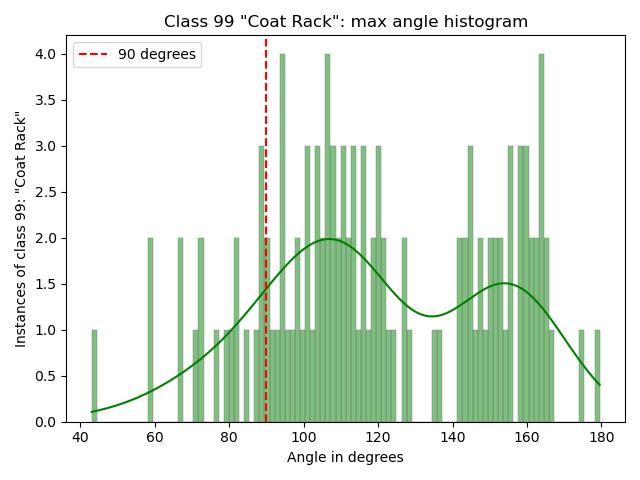

In [20]:
# Create the histogram for the CLASS explored
histogram_path = plot_class_angle_histogram(CLASS_NUM)
display(Image(filename=histogram_path))